In [1]:
import torch 
from torch import nn
from torch.autograd import Variable
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torchvision.datasets as dsets
import torchvision.transforms as T
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
sns.set(color_codes=True)
np.set_printoptions(precision=4, suppress=True)

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap="Blues")
    return 

In [3]:
batch_size = 100

In [4]:
T_train = T.Compose(
            [
             T.RandomHorizontalFlip(),
             T.RandomRotation(degrees=20),
             T.ToTensor(),
             ] 
            )
T_test = T.Compose(
            [
                T.ToTensor(),
            ]
            )
mnist_train = dsets.MNIST(root='./data', train=True, transform=T_train, download=True)
mnist_test = dsets.MNIST(root='./data', train=False, transform=T_test, download=True)
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=5)
mnist_test_loader = DataLoader(mnist_test, batch_size=mnist_test.__len__(), shuffle=False, num_workers=5)

In [ ]:
show_images(mnist_train_loader.__iter__().next()[0].numpy())

In [5]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        N = x.size(0)
        return x.view(N, -1)

In [29]:
model = nn.Sequential(
        nn.Conv2d(1, 32, (4, 4), 1, padding=0), # (28 - 4 + 2*0) / 1 + 1 = 25
        nn.ReLU(inplace=True), 
        nn.Conv2d(32, 32, (4, 4), 1, padding=0), # (25 - 4 + 2*0) / 1 + 1 = 22
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, (4, 4), 2, padding=1), # (22 - 4 + 2*1) / 2 + 1 = 11
        nn.ReLU(inplace=True),
#         nn.Dropout2d(p=0.25),
        Flatten(),
        nn.Linear(11*11*32, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(128, 10)
        )
model.cuda(2)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (3): ReLU(inplace)
  (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU(inplace)
  (6): Flatten(
  )
  (7): Linear(in_features=3872, out_features=128, bias=True)
  (8): ReLU(inplace)
  (9): Dropout(p=0.5)
  (10): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
criterion = nn.CrossEntropyLoss()
criterion.cuda(2)
optim = torch.optim.Adam(model.parameters(), lr=3e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

In [40]:
epoch = 40
for e in range(epoch, epoch+1):
    model.train()
    lr_scheduler.step()
    for step, (images, labels) in enumerate(mnist_train_loader):
        optim.zero_grad()
        x, y = Variable(images.cuda(2)), Variable(labels.cuda(2))
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optim.step()
        if step % 100 == 0:
            print 'epoch: [{0:d}], iter: {1: d}, loss: [{2: .4f}]'.format(e, step, loss.data.cpu()[0])
            eval()

epoch: [40], iter:  0, loss: [ 0.1998]
test acc: 0.9919
epoch: [40], iter:  100, loss: [ 0.0149]
test acc: 0.9919
epoch: [40], iter:  200, loss: [ 0.0120]
test acc: 0.9919
epoch: [40], iter:  300, loss: [ 0.0071]
test acc: 0.9919
epoch: [40], iter:  400, loss: [ 0.0045]
test acc: 0.9919
epoch: [40], iter:  500, loss: [ 0.0133]
test acc: 0.9919


In [8]:
def eval():
    model.eval()
    for images, labels in mnist_test_loader:
        x = Variable(images.cuda(2))
        logits = model(x)
        _, labels_pred = torch.max(logits, 1)
        print 'test acc: {}'.format(np.mean((labels_pred.data.cpu() == labels)))

In [39]:
from sklearn.metrics import confusion_matrix

In [61]:
y_test = mnist_test_loader.__iter__().next()[1].cpu().numpy()
for images, _ in mnist_test_loader:
    x = Variable(images.cuda(2))
    logits = model(x)
    _, labels_pred = torch.max(logits, 1)

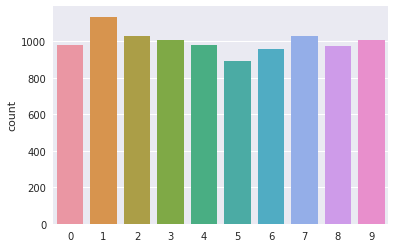

In [67]:
sns.countplot(y_test)

In [68]:
cm = confusion_matrix(labels_pred.data.cpu().numpy(), y_test)

Text(33,0.5,u'Pred')

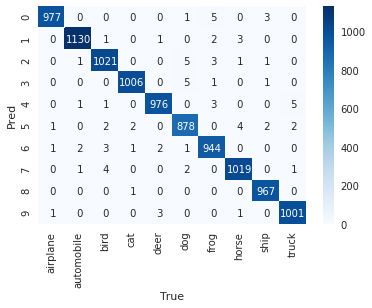

In [73]:
sns.heatmap(cm, fmt='2d', annot=True, cmap='Blues', 
            xticklabels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
           )
plt.xlabel('True')
plt.ylabel('Pred')

In [38]:
import pandas as pd

data_test = pd.read_csv('../kaggle/mnist/test.csv')

x = Variable(torch.Tensor(data_test.values.reshape([-1, 1, 28, 28]) / 255.).cuda(2))

logits = model(x)
_, labels_pred = torch.max(logits, 1)

labels_predict = labels_pred.data.cpu().numpy()

df = pd.DataFrame(np.concatenate((np.arange(1, 28001)[:, None],labels_predict[:, None]), axis=1), columns=['ImageId', 'Label'])

df.to_csv('submission.csv', index=False)